In [5]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import numpy as np
from typing import List
from utils import dump_dref

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

volatile_locked = Path("allocator/230107-111045-lock")
volatile_ll = Path("allocator/230107-112744-dram")
peristent_ll = Path("allocator/230107-113306-nvram")


def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = o
        data.append(d)
    data = pd.concat(data)
    data["cores"] = data["x"]
    data["alloc"] = data["get_avg"]
    data["free"] = data["put_avg"]
    return data[["order", "cores", "iteration", "alloc", "free"]]


def read_all_bench(dir: Path, orders: List[int]) -> pd.DataFrame:
    data_b = read_orders(dir / "bulk", orders)
    data_b["bench"] = "Bulk"
    data_r = read_orders(dir / "repeat", orders)
    data_r["bench"] = "Repeat"
    data_r["free+alloc"] = data_r["alloc"]
    del data_r["alloc"]
    del data_r["free"]
    data_a = read_orders(dir / "rand", orders)
    data_a["bench"] = "Rand"
    del data_a["alloc"]
    return pd.concat([data_b, data_r, data_a])


def save_dref(name: str, groupby: List[str], data: pd.DataFrame):
    out = {}
    data = data.dropna(axis=0).groupby(groupby).mean(numeric_only=True)
    for index, row in data.iterrows():
        out["/".join(map(str, row.name))] = row.values[0]
    with Path(f"out/{name}.dref").open("w+") as f:
        dump_dref(f, name, out)


# Order Scaling

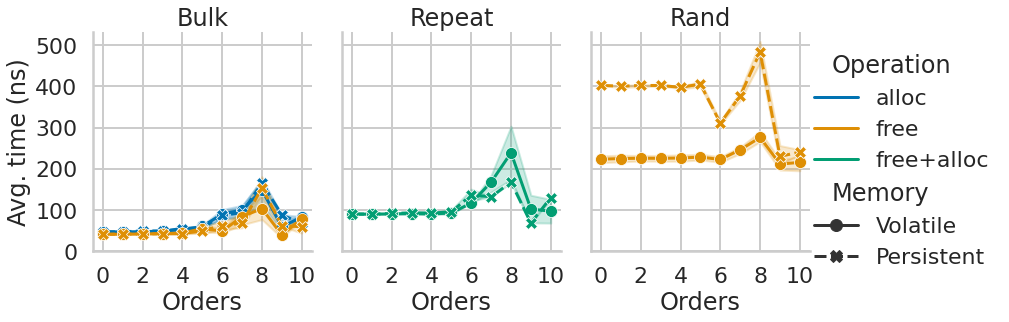

In [6]:
data_v = read_all_bench(volatile_ll, list(range(11)))
data_v["Memory"] = "Volatile"
data_p = read_all_bench(peristent_ll, list(range(11)))
data_p["Memory"] = "Persistent"

data = pd.concat([data_v, data_p])
data = data[data["cores"] == 8]
pgd = data[["bench", "order", "cores", "Memory", "alloc", "free", "free+alloc"]].melt(
    id_vars=["bench", "order", "cores", "Memory"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="bench", height=5, aspect=0.8)
    g.map_dataframe(sns.lineplot, x="order", y="time",
                    markers=True, hue="Operation", style="Memory")
    g.add_legend(adjust_subtitles=True)
    g.set(ylim=(0, None))
    # g.set(ylim=(10, 10**5))
    # g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Orders")
    g.set(xticks=[0, 2, 4, 6, 8, 10])
    g.set_titles("{col_name}")
    g.savefig("out/llfree_orders.pdf")

save_dref("llfree_orders", ["Memory", "bench", "order", "cores", "Operation"], pgd)


# Multicore Scaling

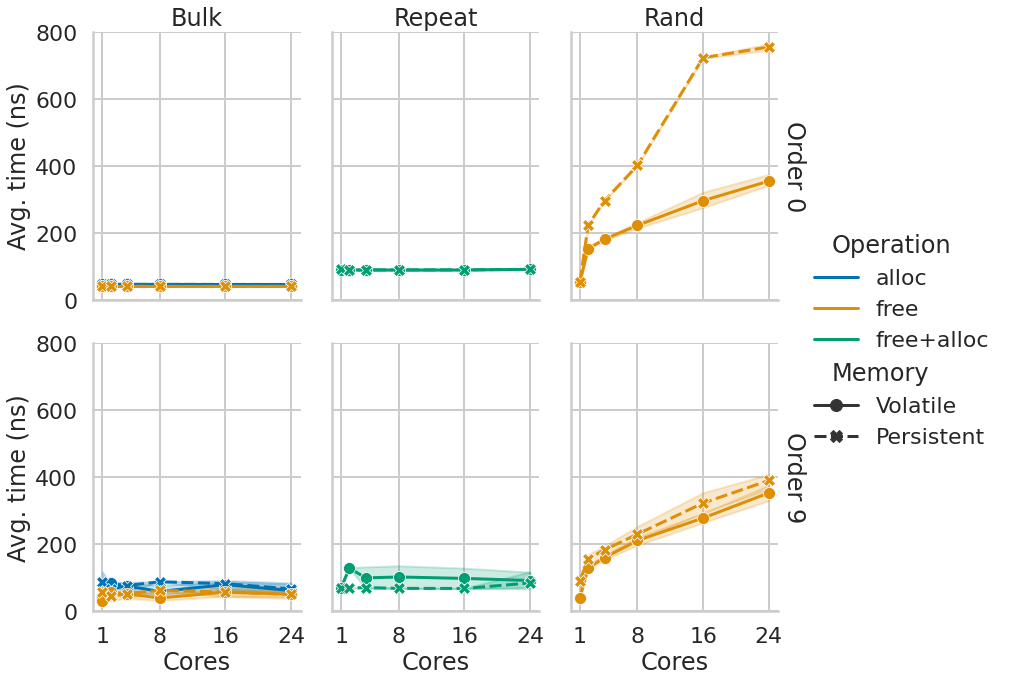

In [7]:
data_v = read_all_bench(volatile_ll, [0, 9])
data_v["Memory"] = "Volatile"
data_p = read_all_bench(peristent_ll, [0, 9])
data_p["Memory"] = "Persistent"

data = pd.concat([data_v, data_p])
pgd = data[["bench", "order", "cores", "Memory", "alloc", "free", "free+alloc"]].melt(
    id_vars=["bench", "order", "cores", "Memory"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, row="order", col="bench",
                      height=5, aspect=0.8, margin_titles=True, )
    g.map_dataframe(sns.lineplot, x="cores", y="time", markers=True,
                    style="Memory", hue="Operation")
    g.add_legend(adjust_subtitles=True)
    g.set(xticks=[1, 8, 16, 24])
    g.set(ylim=(0, None))
    # g.set(ylim=(1, 10**5 * 1.5))
    # g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="Order {row_name}")
    g.savefig("out/llfree_cores.pdf")

save_dref("llfree_orders", ["Memory", "bench", "order", "cores", "Operation"], pgd)


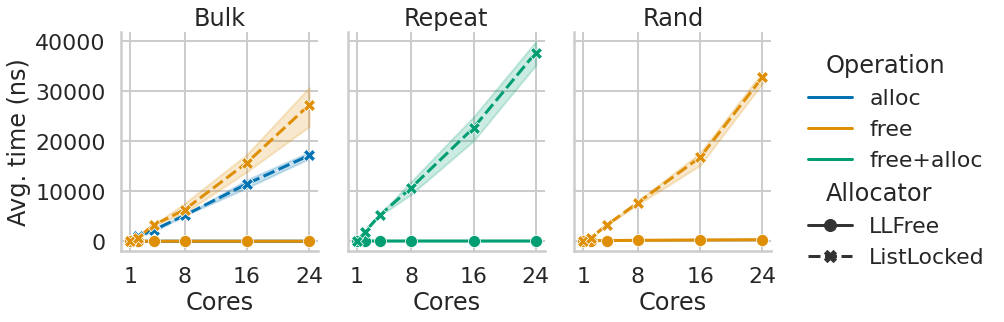

In [8]:
data_v = read_all_bench(volatile_ll, [0])
data_v["Allocator"] = "LLFree"
data_vl = read_all_bench(volatile_locked, [0])
data_vl["Allocator"] = "ListLocked"

data = pd.concat([data_v, data_vl])
pgd = data[["bench", "order", "cores", "Allocator", "alloc", "free", "free+alloc"]].melt(
    id_vars=["bench", "order", "cores", "Allocator"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="bench",
                      height=5, aspect=0.8, margin_titles=True, )
    g.map_dataframe(sns.lineplot, x="cores", y="time", markers=True,
                    style="Allocator", hue="Operation")
    g.add_legend(adjust_subtitles=True)
    g.set(xticks=[1, 8, 16, 24])
    # g.set(ylim=(0, None))
    # g.set(ylim=(1, 10**5 * 1.5))
    # g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="Order {row_name}")
    g.savefig("out/llfree_locked.pdf")

save_dref("llfree_orders", ["Allocator", "bench", "cores", "Operation"], pgd)
